# CSE6250BDH FINAL PROJECT
## Predicting Heart Failure Readmission from Clinical Notes Using Deep Learning (CNN)


In [1]:
import torch
import pandas as pd
import numpy as np
import math
import datetime
import builtins
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from gensim.models import KeyedVectors
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from string import punctuation
import time
import os
import psutil
from utility import *
from ReadmissionCNN import *
from torch.utils.data import TensorDataset, Dataset
import torch.optim as optim

from sklearn.model_selection import train_test_split



nltk.download('stopwords')
nltk.download('punkt')

n_cores = psutil.cpu_count(logical=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(f"number of cores: {n_cores}")
print(torch.__version__)

number of cores: 8
2.0.0+cu118


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


True
1
0
Quadro RTX 4000
Using device: cuda


In [4]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Quadro RTX 4000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
def custom_print(*args, **kwargs):
    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    builtins.print(f"[{dt_string}] -", *args, **kwargs)

# Override the built-in print function
print = custom_print    

# Restore the original print function
print = builtins.print


# DATA PRE-PROCESSING

In [6]:
stop_words = set(stopwords.words('english'))
pattern = r'\b[a-zA-Z]+\b' # regex pattern for matching words only
regex_tokenizer = RegexpTokenizer(pattern)
#regex_tokenizer = RegexpTokenizer(r'\w+') # \w+ tokenizes the input text into words, extracting sequences of alphanumeric characters as tokens and ignoring punctuations and whitespace.


def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    

    tokens = [token for token in regex_tokenizer.tokenize(text) 
             if token not in punctuation and 
             token not in stop_words
            ]

    
    processed_text = ' '.join(tokens).replace('unit numeric identifier', '') \
                                     .replace('admission date', '') \
                                     .replace('discharge date', '')\
                                     .replace('date birth', '')

    return processed_text.strip()

In [8]:
hf_admission_notes_with_labels = pd.read_csv('.\data\mimic_hf_admission_notes_with_readmission_labels.csv')

hf_admission_notes_with_labels.shape

(13746, 7)

In [9]:
hf_admission_notes_with_labels.head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0


In [ ]:
len(hf_admission_notes_with_labels.iloc[0,2].split(" "))

In [ ]:
hf_admission_notes_with_labels[["READMISSION","READMISSION_30DAYS"]].agg(["sum","count"])

### TOKENIZE AND PROCESS CLINICAL NOTES

In [10]:
hf_admission_notes_with_labels['TEXT_LEN'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: len(words.split(" ")))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: preprocess_sentence(words))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'] = hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'].apply(lambda words: len(words.split(" ")))

hf_admission_notes_with_labels.head()
#hf_admission_notes_with_labels.sort_values("TEXT_LEN",ascending=False).head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,839,sex service admission diagnosis pneumonia colo...,511
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,3668,sex service medicine allergies known allergies...,2596
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,1658,sex service medicine allergies penicillins att...,1165
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,669,service company medicine outside hospital panc...,436
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,2431,sex service medicine allergies known allergies...,1726


In [ ]:
hf_admission_notes_with_labels.iloc[1,8]

Avg Tokenized & Processed Notes Length: 1157.3649789029537
Max Tokenized & Processed Notes Length: 4650
Min Tokenized & Processed Notes Length: 24
Std Tokenized & Processed Notes Length: 506.20113787888295
3092


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,839,sex service admission diagnosis pneumonia colo...,511
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,3668,sex service medicine allergies known allergies...,2596
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,1658,sex service medicine allergies penicillins att...,1165
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,669,service company medicine outside hospital panc...,436
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,2431,sex service medicine allergies known allergies...,1726


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


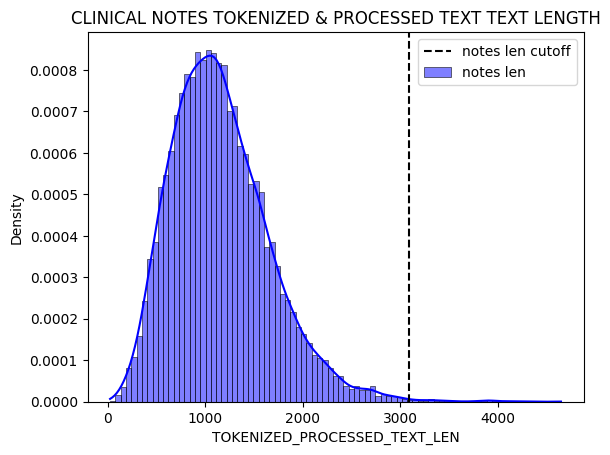

In [11]:
hf_admission_notes_with_labels["TOKENIZED_PROCESSED_TEXT_LEN"].max()

#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
notes_len_cutoff = np.round(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean() + 3*hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()).astype(int) 


#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q75, q25 = np.percentile(hf_admission_notes_with_labels['TEXT_LEN'], [75 ,25])
iqr = q75 - q25
notes_len_cutoff = np.round(q75 + (1.1 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(notes_len_cutoff)
display(hf_admission_notes_with_labels.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT TEXT LENGTH'); plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO MATCH READMISSION SAMPLES 

### BALANCED SAMPLE DATASET

In [135]:

# Separate majority and minority classes
hf_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 0]
hf_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 1]
# Downsample majority class
#hf_readmission_notes_majority_downsampled = hf_readmission_notes_majority.sample(n=len(hf_readmission_notes_minority), random_state=42)
hf_readmission_notes_majority_downsampled = hf_readmission_notes_majority.sample(n=len(hf_readmission_notes_minority))

# Combine minority class with downsampled majority class
hf_readmission_notes_balanced = pd.concat([hf_readmission_notes_majority_downsampled, hf_readmission_notes_minority])

print("Overall Balanced dataset")
print(hf_readmission_notes_balanced.READMISSION.value_counts())

# Shuffle the dataset to prevent the model from learning any order
hf_readmission_notes_balanced = hf_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#print("40% Balanced dataset")
#fraction = 0.4  ## For example, 40% of each class
#hf_readmission_notes_balanced = hf_readmission_notes_balanced.groupby('READMISSION', group_keys=False).apply(lambda x: x.sample(frac=fraction))
# Display new class counts
#print(hf_readmission_notes_balanced.READMISSION.value_counts())

Overall Balanced dataset
READMISSION
0    3543
1    3543
Name: count, dtype: int64


Avg Tokenized & Processed Notes Length: 1184.5921535421958
Max Tokenized & Processed Notes Length: 4290
Min Tokenized & Processed Notes Length: 24
Std Tokenized & Processed Notes Length: 507.8132449915151
Readmission Nots Cutoff Length: 3335


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,157364,9706,Admission Date: [**2143-3-28**] ...,Report,2143-03-28 04:13:00,0,0,2082,service medicine allergies levofloxacin attend...,1400
1,116545,5544,Admission Date: [**2123-11-10**] ...,Report,2123-11-10 19:04:00,1,0,3052,sex service medicine allergies tetracycline an...,2152
2,180995,10248,Admission Date: [**2167-7-3**] Discharg...,Report,2167-07-03 22:26:00,0,0,1033,sex service history present illness patient ye...,560
3,102652,27232,Admission Date: [**2179-7-14**] ...,Report,2179-07-14 15:05:00,1,1,1868,sex service surgery allergies patient recorded...,1308
4,129153,11897,Admission Date: [**2120-9-4**] D...,Report,2120-09-04 18:21:00,1,0,1410,sex f service med allergies penicillins zaroxo...,1012


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


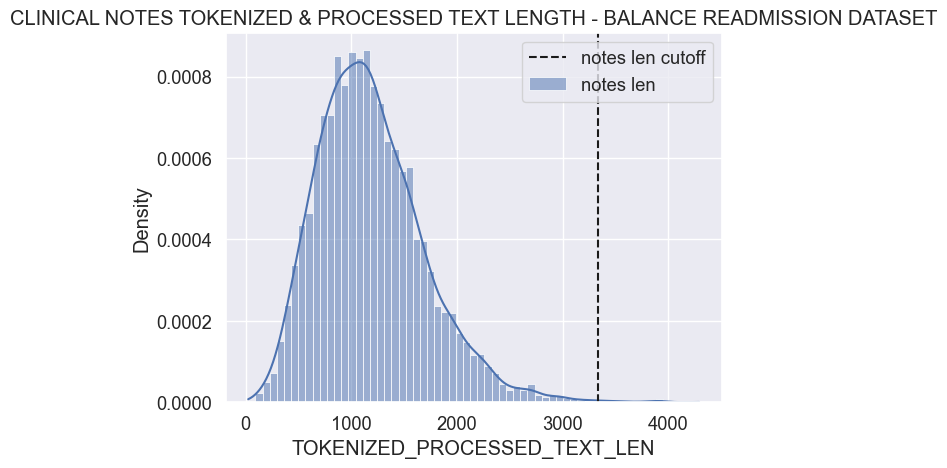

In [136]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#readmission_notes_len_cutoff = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(readmission_notes_len_cutoff)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], [90 ,25])
iqr = q85 - q25
readmission_notes_len_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(f"Readmission Nots Cutoff Length: {readmission_notes_len_cutoff}")
display(hf_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=readmission_notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE READMISSION DATASET'); 
plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO 30-DAY READMISSION SAMPLE 
### BALANCED SAMPLE DATASET

In [137]:

# Separate majority and minority classes
hf_30day_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 0]
hf_30day_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 1]
# Downsample majority class
hf_30day_readmission_notes_majority_downsampled = hf_30day_readmission_notes_majority.sample(n=len(hf_30day_readmission_notes_minority), random_state=42)
# Combine minority class with downsampled majority class
hf_30day_readmission_notes_balanced = pd.concat([hf_30day_readmission_notes_majority_downsampled, hf_30day_readmission_notes_minority])
# Shuffle the dataset to prevent the model from learning any order
hf_30day_readmission_notes_balanced = hf_30day_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Display new class counts
print(hf_30day_readmission_notes_balanced.READMISSION_30DAYS.value_counts())

READMISSION_30DAYS
1    962
0    962
Name: count, dtype: int64


Avg Tokenized & Processed Notes Length: 1243.0031185031185
Max Tokenized & Processed Notes Length: 4147
Min Tokenized & Processed Notes Length: 137
Std Tokenized & Processed Notes Length: 513.3587127506346
30 Day Readmission Nots Cutoff Length: 3425


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,165332,32348,Admission Date: [**2145-7-13**] ...,Report,2145-07-13 00:59:00,1,1,1985,sex service medicine allergies clonidine atten...,1366
1,170535,30348,Admission Date: [**2185-12-28**] ...,Report,2185-12-28 13:15:00,1,1,1215,service medicine allergies sulfa sulfonamides ...,855
2,111925,69265,Admission Date: [**2194-5-15**] ...,Report,2194-05-15 17:42:00,0,0,2478,sex service medicine allergies known allergies...,1328
3,128989,27043,Admission Date: [**2141-10-21**] ...,Report,2141-10-21 06:35:00,0,0,1682,sex service medicine allergies patient recorde...,1233
4,147206,75031,Admission Date: [**2198-3-28**] ...,Report,2198-03-28 01:09:00,0,0,2592,sex service medicine allergies patient recorde...,1677


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


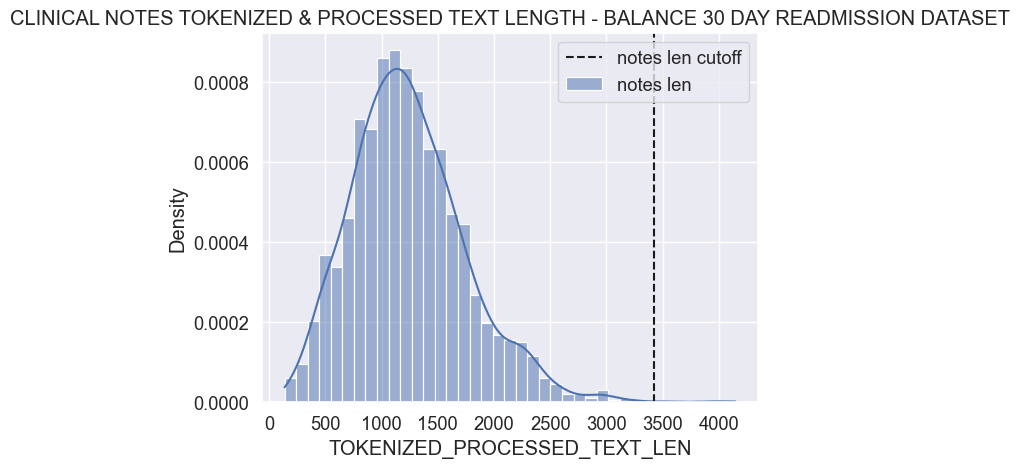

In [138]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#max_text_len_readmission = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(max_text_len_readmission)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], [90 ,25])
iqr = q85 - q25
_30dayreadmission_notes_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(f"30 Day Readmission Nots Cutoff Length: {_30dayreadmission_notes_cutoff}")
display(hf_30day_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=_30dayreadmission_notes_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE 30 DAY READMISSION DATASET'); plt.legend()
plt.show()


## SPLIT DATA IN TRAIN TEST

### READMISSION BALANCED DATASET 90/10 SPLIT 

In [157]:
## READMISSION BALANCED DATASET 90/10 SPLIT 
readmission_notes_features = hf_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT"]]
readmission_notes_target = hf_readmission_notes_balanced["READMISSION"]
X_readmission_train, X_readmission_test, y_readmission_train, y_readmission_test = train_test_split(readmission_notes_features, readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_readmission_test.shape}")


readmission_notes_features Shape: (7086, 1)
X_readmission_train Shape: (6377, 1)
X_readmission_test Shape: (709, 1)
y_readmission_train Shape: (6377,)
y_readmission_test Shape: (709,)


In [158]:
## 30-DAY READMISSION BALANCED DATASET 90/10 SPLIT 
_30day_readmission_notes_features = hf_30day_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT"]]
_30day_readmission_notes_target = hf_30day_readmission_notes_balanced["READMISSION_30DAYS"]
X_30day_readmission_train, X_30day_readmission_test, y_30day_readmission_train, y_30day_readmission_test = train_test_split(_30day_readmission_notes_features, _30day_readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {_30day_readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_30day_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_30day_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_30day_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_30day_readmission_test.shape}")

readmission_notes_features Shape: (1924, 1)
X_readmission_train Shape: (1731, 1)
X_readmission_test Shape: (193, 1)
y_readmission_train Shape: (1731,)
y_readmission_test Shape: (193,)


# LOAD PUBMED & PMC WORD2VEC MODEL INTO MEMORY

In [18]:
# Load the Word2Ven model (substitute with the path to your downloaded vectors)
# The model can be downloaded from: https://bio.nlplab.org/#word-vector-tools
# Word vectors > http://evexdb.org/pmresources/vec-space-models/
#PubMed abstract and PMC full text vector model  = './vector_embeddings/PubMed-and-PMC-w2v.bin'

## This is large file, I did not check into Github repository, please download it from the above location and place it in vector_embeddings folder

start_time = time.time()
pubmed_pmc_wordvector_path = './vector_embeddings/PubMed-and-PMC-w2v.bin'
pubmed_pmc_wordvector = KeyedVectors.load_word2vec_format(pubmed_pmc_wordvector_path, binary=True)
end_time = time.time()
pubmed_pmc_wordvector_model_load_elapsed_time = round(end_time - start_time,4)
print(f'PubMed & PMC vector model was successfully loaded in {utility.parse_time(pubmed_pmc_wordvector_model_load_elapsed_time)}')
print(f'Pubmed & PMC Word2Vec model Embedding Dimension: {pubmed_pmc_wordvector.vector_size}')

PubMed & PMC vector model was successfully loaded in 33.91 sec
Pubmed & PMC Word2Vec model Embedding Dimension: 200


In [19]:

def get_embedding_vector(word, model):
    # This function returns the embedding vector for a word from the pre-trained model
    try:
        return model[word]
    except KeyError:
        # If the word is not in the model, return a zero vector
        return np.zeros(model.vector_size)

# Initialize an empty list to hold all record embeddings

def convert_to_tensor_dataset(embeddings, target_labels):
    # Now `embedding_tensor` is a 3D tensor of shape (number_of_records, fixed_length, embedding_dimension)
    embeddings_stacked = np.stack(embeddings)
    embedding_tensor = torch.from_numpy(embeddings_stacked).unsqueeze(1)
    #target = torch.from_numpy(target.astype('long')).view(-1,1)
    target_tensor = torch.from_numpy(target_labels.values)
    embedding_tensor_dataset = TensorDataset(embedding_tensor, target_tensor)    	
    return embedding_tensor_dataset

def get_embeddings_of_tokenized_words(df_to_embedd, notes_len_cutoff, embedding_w2v_model):
    
    embeddings = []

    # Iterate over each record in the DataFrame
    for _, row in df_to_embedd.iterrows():
        # Initialize the embedding matrix for this record with zeros
        notes_embedding_matrix = np.zeros((notes_len_cutoff, embedding_w2v_model.vector_size))
        
        # Iterate over the tokenized words up to the fixed_length
        for i, word in enumerate(row['TOKENIZED_PROCESSED_TEXT'][:notes_len_cutoff]):
            # Get the embedding vector for the word
            notes_embedding_matrix[i] = get_embedding_vector(word, embedding_w2v_model)
        
        # Add the record's embedding matrix to the list
        embeddings.append(notes_embedding_matrix)

    #print(f'Embeddings Length: {len(embeddings)}')
    # Convert the list of embeddings into a 3D NumPy array
    #embeddings_stacked = np.stack(embeddings)
    #print(embeddings_stacked)
    #print(f'Stacked Embeddings Dimensions: {len(embeddings)}')
    #print(f'Stacked Embeddings Dimensions: {embeddings.shape}')

    # Now `embedding_tensor` is a 3D tensor of shape (number_of_records, fixed_length, embedding_dimension)
    #embedding_tensor = torch.from_numpy(embeddings_stacked).unsqueeze(1)
    #target = torch.from_numpy(target.astype('long')).view(-1,1)
    #target_tensor = torch.from_numpy(y_labels.values)
    #embedding_tensor_dataset = TensorDataset(embedding_tensor, target_tensor)

    #print(f'Embeddings Tensor Dataset Dimensions: {embedding_tensor_dataset.tensors[0].shape}')
    
    return embeddings
    


In [20]:
class TextEmbeddingDataset(Dataset):
    def __init__(self, tokenized_notes, labels, pubmed_pmc_embedding_model):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing tokenized text and labels.
            embedding_model (Model): Pre-trained model to generate embeddings.
        """
        self.tokenized_notes = tokenized_notes
        self.labels = labels.tolist()
        self.pubmed_pmc_embedding_model = pubmed_pmc_embedding_model

    def __len__(self):
        return len(self.tokenized_notes)

    def get_embedding_vector(self, word):
        # This function returns the embedding vector for a word from the pre-trained model
        try:
            return self.pubmed_pmc_embedding_model[word]
        except KeyError:
            # If the word is not in the model, return a zero vector
            return np.zeros(self.pubmed_pmc_embedding_model.vector_size)
        
    def __getitem__(self, idx):
        
        #print(f"Accessing index: {idx}") 

        if torch.is_tensor(idx):
            idx = idx.tolist()
        #print(f"Accessing index: {idx}") 

        
        # Extract tokenized text and label
        tokenized_text = self.tokenized_notes.iloc[idx, 0]  # assuming tokenized text is in the first column
        #print(display(tokenized_text))
        labels = self.labels[idx]  # assuming label is in the second column
        #print(labels)
        

        embeddings = []
        
        # Initialize the embedding matrix for this record with zeros
        notes_embedding_matrix = np.zeros((notes_len_cutoff, self.pubmed_pmc_embedding_model.vector_size))
        
        # Iterate over the tokenized words up to the fixed_length
        for i, word in enumerate(tokenized_text[:notes_len_cutoff]):
            # Get the embedding vector for the word
            notes_embedding_matrix[i] = self.get_embedding_vector(word)
        
        #print(notes_embedding_matrix.shape)
        # Add the record's embedding matrix to the list
        #embeddings.append(notes_embedding_matrix)
        
        #embeddings_stacked = np.stack(embeddings)
        #notes_embedding_stacked = np.stack(notes_embedding_matrix)
        embedding_tensor = torch.from_numpy(notes_embedding_matrix).unsqueeze(0)
        #print(embedding_tensor.shape)
        # Convert label to tensor
        label_tensor = torch.tensor(labels, dtype=torch.long)

        return embedding_tensor, label_tensor

In [21]:
readmission_train_dataset = TextEmbeddingDataset(X_readmission_train[1:10], y_readmission_train[1:10], pubmed_pmc_wordvector)
readmission_test_dataset = TextEmbeddingDataset(X_readmission_test[1:10], y_readmission_test[1:10], pubmed_pmc_wordvector)    
for i in range(min(5, len(readmission_train_dataset))):
    embedding, label = readmission_train_dataset[i]
    print(f"Embedding: {embedding.shape}, Label: {label}")

Embedding: torch.Size([1, 3092, 200]), Label: 1
Embedding: torch.Size([1, 3092, 200]), Label: 0
Embedding: torch.Size([1, 3092, 200]), Label: 0
Embedding: torch.Size([1, 3092, 200]), Label: 1
Embedding: torch.Size([1, 3092, 200]), Label: 0


In [22]:
class TextDataset(Dataset):
    def __init__(self, tokenized_notes, labels):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing tokenized text and labels.
            embedding_model (Model): Pre-trained model to generate embeddings.
        """
        self.tokenized_notes = tokenized_notes
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.tokenized_notes)

       
    def __getitem__(self, idx):        
        #print(self.tokenized_notes.iloc[idx, 0])
        text = self.tokenized_notes.iloc[idx, 0]
        label = self.labels[idx]
        return text, label
    
def create_collate_fn(embedding_model, notes_len_cutoff):

    def custom_collate_fn(batch):
        
        def get_embedding_vector(word, model):
            # This function returns the embedding vector for a word from the pre-trained model
            try:
                return model[word]
            except KeyError:
                # If the word is not in the model, return a zero vector
                return np.zeros(model.vector_size)

        #print(embedding_model.vector_size)

        batch_tokenized_notes, labels = zip(*batch)
        #print(batch_tokenized_notes)
        # Apply embeddings to the entire batch of texts
        #batch_embeddings = embedding_model(list(texts))

        batch_embeddings = []

        # Iterate over each record in the DataFrame
        for tokenized_note in batch_tokenized_notes:
           
            # Initialize the embedding matrix for this record with zeros
            notes_embedding_matrix = np.zeros((notes_len_cutoff, embedding_model.vector_size))
            
            # Iterate over the tokenized words up to the fixed_length
            for i, word in enumerate(tokenized_note[:notes_len_cutoff]):
                # Get the embedding vector for the word
                notes_embedding_matrix[i] = get_embedding_vector(word, embedding_model)
            
            # Add the record's embedding matrix to the list
            batch_embeddings.append(notes_embedding_matrix)

        # Convert the list of embeddings into a 3D NumPy array
        batch_embeddings_stacked = np.stack(batch_embeddings)
        #print(batch_embeddings_stacked.shape)
        
        batch_embeddings_tensor = torch.from_numpy(batch_embeddings_stacked).unsqueeze(1)
        # Convert the batch of embeddings and labels to tensors
        #batch_embeddings_tensor = torch.stack(batch_embeddings)
        #print(batch_embeddings_tensor.shape)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return batch_embeddings_tensor, labels_tensor

    return custom_collate_fn

In [23]:
collate_fn = create_collate_fn(pubmed_pmc_wordvector, readmission_notes_len_cutoff)
# Creating the DataLoader with the custom collate function
readmission_train_dataset_noembed = TextDataset(X_readmission_train[1:50], y_readmission_train[1:50])
readmission_test_dataset_noembed = TextDataset(X_readmission_test[1:2], y_readmission_test[1:2])        

dataloader = torch.utils.data.DataLoader(readmission_train_dataset_noembed, batch_size=32, collate_fn=collate_fn)
for i, (embeddings, labels) in enumerate(dataloader):
    print(f"Batch {i}")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Labels: {labels}")
    # Add any additional inspection or debugging code here

    if i == 10:  # Change this number to see more or fewer batches
        break

Batch 0
Embeddings shape: torch.Size([32, 1, 3335, 200])
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0])
Batch 1
Embeddings shape: torch.Size([17, 1, 3335, 200])
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1])


In [107]:
filter_sizes = [5,4,3]
N_FILTERS = [1000,750,500] 
[(fs,fltr) for fs, fltr in zip(filter_sizes,N_FILTERS)]

[(5, 1000), (4, 750), (3, 500)]

In [139]:

class ReadmissionCNN_Local(nn.Module):
    def __init__(self, n_filters, filter_sizes, output_dim, dropout, embedding_dim):
        super().__init__()
        
        # Since we already have embeddings, we won't use an embedding layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers with in_channels=1 because our input is not an image but an embedded text
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = fltr,
                                              kernel_size=(fs, embedding_dim)) 
                                    for fs,fltr in zip(filter_sizes,n_filters)
                                    ])
        
        # Fully connected layer
        #self.fc = nn.Linear(sum(n_filters), output_dim)

        self.fc1 = nn.Linear(sum(n_filters), 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded):
        # embedded is already a tensor with size [batch size, notes len, emb dim]
        # We add an extra dimension for the "channel" which is 1 here
        #embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, notes len, emb dim]
        
        # Convolution and pooling layers
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        # Max pooling over time
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        
        # Concatenate the pooled features from different filter sizes
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        x = self.dropout(F.relu(self.fc1(cat))) 
        x = self.dropout(F.relu(self.fc2(x))) 
        # Fully connected layer
        return self.fc3(x)

In [166]:
import math

BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

#batch_percent = 0.2
#readmission_balanced_dataset_len =  len(hf_readmission_notes_balanced)
#readmission_balanced_dataset_batchsize =  math.ceil(readmission_balanced_dataset_len * batch_percent)

# Create an instance of your custom dataset

readmission_train_dataset_noembed = TextDataset(X_readmission_train, y_readmission_train)
readmission_test_dataset_noembed = TextDataset(X_readmission_test, y_readmission_test)        

collate_fn = create_collate_fn(pubmed_pmc_wordvector, readmission_notes_len_cutoff)

train_loader_readmission_embed = torch.utils.data.DataLoader(readmission_train_dataset_noembed, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader_readmission_embed = torch.utils.data.DataLoader(readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

#from ReadmissionCNN import *
PATH_OUTPUT = "./output_fullDS/readmission/"

# Hyperparameters
N_FILTERS = [1000,1000,1000]  # number of filters
FILTER_SIZES = [3,4,5]  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = 0.3  # dropout rate
EMBEDDING_DIM = 200  # embedding dimension

# Create an instance of the CNN class
cnn_readmission_model_collatefn = ReadmissionCNN_Local(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_readmission_model_collatefn = cnn_readmission_model_collatefn.to(device)

# Define loss function and optimizer
criterion_collatefn = nn.CrossEntropyLoss().to(device)
optimizer_collatefn = torch.optim.Adam(cnn_readmission_model_collatefn.parameters())


NUM_EPOCHS = 15
best_val_acc_collatefn = 0.0
train_losses_collatefn, train_accuracies_collatefn = [], []
valid_losses_collatefn, valid_accuracies_collatefn = [], []

for epoch in range(NUM_EPOCHS):

	train_loss_collatefn, train_accuracy_collatefn = utility.train(cnn_readmission_model_collatefn, device, train_loader_readmission_embed, criterion_collatefn, optimizer_collatefn, epoch)
	valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn = utility.evaluate(cnn_readmission_model_collatefn, device, test_loader_readmission_embed, criterion_collatefn)

	train_losses_collatefn.append(train_loss_collatefn)
	valid_losses_collatefn.append(valid_loss_collatefn)

	train_accuracies_collatefn.append(train_accuracy_collatefn)
	valid_accuracies_collatefn.append(valid_accuracy_collatefn)

	is_best_collatefn = valid_accuracy_collatefn > best_val_acc_collatefn  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best_collatefn:
		print(f"Best Validation Accuracy: {valid_accuracy_collatefn}")
		best_val_acc_collatefn = valid_accuracy_collatefn
		torch.save(cnn_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_model_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)

Epoch: [0][0/200]	Time 0.854 (0.854)	Data 0.225 (0.225)	Loss 0.6909 (0.6909)	Accuracy 56.250 (56.250)
Epoch: [0][10/200]	Time 1.902 (1.821)	Data 1.650 (1.539)	Loss 0.7781 (0.7450)	Accuracy 46.875 (46.875)
Epoch: [0][20/200]	Time 1.903 (1.858)	Data 1.654 (1.592)	Loss 0.7150 (0.7386)	Accuracy 46.875 (48.214)
Epoch: [0][30/200]	Time 1.903 (1.878)	Data 1.649 (1.616)	Loss 0.7106 (0.7272)	Accuracy 46.875 (48.387)
Epoch: [0][40/200]	Time 1.926 (1.891)	Data 1.677 (1.632)	Loss 0.7111 (0.7192)	Accuracy 53.125 (50.152)
Epoch: [0][50/200]	Time 1.919 (1.890)	Data 1.677 (1.634)	Loss 0.6814 (0.7150)	Accuracy 59.375 (49.939)
Epoch: [0][60/200]	Time 1.872 (1.888)	Data 1.621 (1.633)	Loss 0.6924 (0.7103)	Accuracy 56.250 (50.922)
Epoch: [0][70/200]	Time 1.876 (1.887)	Data 1.625 (1.632)	Loss 0.6679 (0.7082)	Accuracy 59.375 (51.012)
Epoch: [0][80/200]	Time 1.893 (1.887)	Data 1.638 (1.633)	Loss 0.7029 (0.7072)	Accuracy 37.500 (50.386)
Epoch: [0][90/200]	Time 1.868 (1.888)	Data 1.610 (1.634)	Loss 0.6860 (0.70

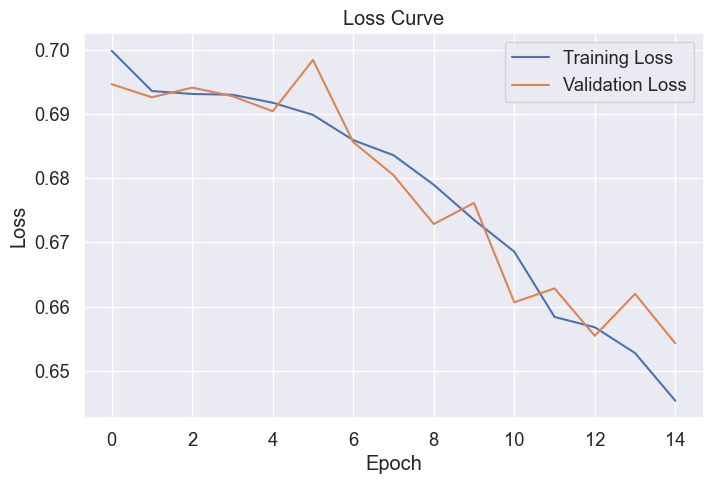

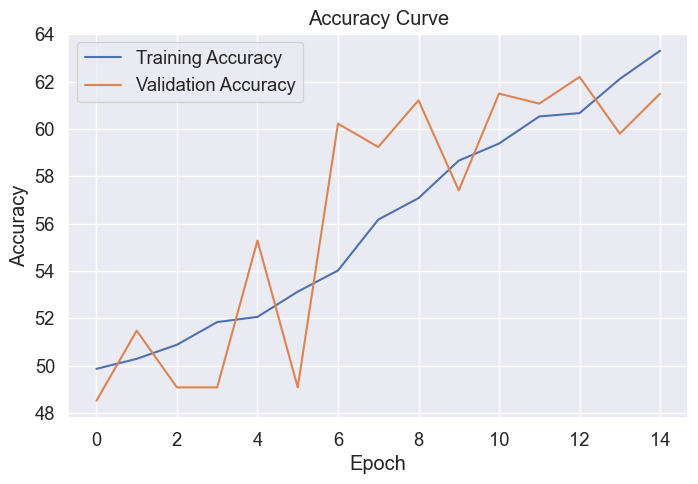

Test: [0/23]	Time 0.277 (0.277)	Loss 0.6294 (0.6294)	Accuracy 71.875 (71.875)
Test: [10/23]	Time 0.553 (0.515)	Loss 0.7253 (0.6571)	Accuracy 43.750 (61.364)
Test: [20/23]	Time 0.536 (0.526)	Loss 0.7080 (0.6554)	Accuracy 50.000 (61.607)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


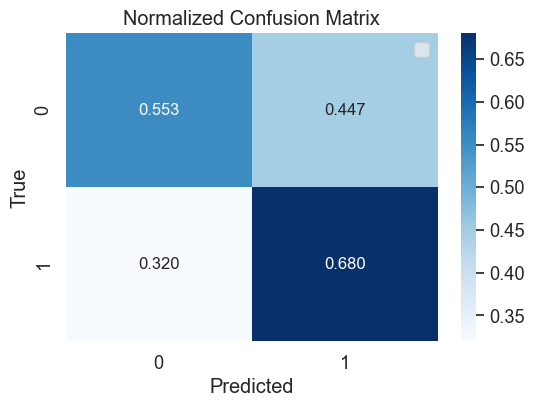

Maximum train accuracy: 63.30562960879078
Maximum test accuracy: 62.20028208744711
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       365
           1       0.59      0.68      0.63       344

    accuracy                           0.61       709
   macro avg       0.62      0.62      0.61       709
weighted avg       0.62      0.61      0.61       709

Accuracy: 0.614950634696756
F1 Score: 0.631578947368421


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score

utility.plot_learning_curves(train_losses_collatefn, valid_losses_collatefn, train_accuracies_collatefn, valid_accuracies_collatefn)

best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_model_collatefn_fullDS.pth"))
valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn = utility.evaluate(cnn_readmission_model_collatefn, device, test_loader_readmission_embed, criterion_collatefn)

class_names = [0,1]
utility.plot_confusion_matrix(valid_results_collatefn, class_names)

y_true_collatefn, y_pred_collatefn = zip(*valid_results_collatefn)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracy_collatefn)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies_collatefn)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true_collatefn, y_pred_collatefn))
print("Accuracy:", accuracy_score(y_true_collatefn, y_pred_collatefn))
print("F1 Score:", f1_score(y_true_collatefn, y_pred_collatefn, average='binary'))

In [180]:
import math

BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

#batch_percent = 0.2
#readmission_30day_balanced_dataset_len =  len(hf_readmission_30day_notes_balanced)
#readmission_30day_balanced_dataset_batchsize =  math.ceil(readmission_30day_balanced_dataset_len * batch_percent)

# Create an instance of your custom dataset

readmission_30day_train_dataset_noembed = TextDataset(X_30day_readmission_train, y_30day_readmission_train)
readmission_30day_test_dataset_noembed = TextDataset(X_30day_readmission_test, y_30day_readmission_test)        

collate_fn = create_collate_fn(pubmed_pmc_wordvector, _30dayreadmission_notes_cutoff)

train_loader_readmission_30day_embed = torch.utils.data.DataLoader(readmission_30day_train_dataset_noembed, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader_readmission_30day_embed = torch.utils.data.DataLoader(readmission_30day_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

#from readmission_30dayCNN import *
PATH_OUTPUT = "./output_fullDS/readmission_30day/"

# Hyperparameters
N_FILTERS = [500,500,250,250]  # number of filters
FILTER_SIZES = [3,4,3,4]  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = 0.3  # dropout rate
EMBEDDING_DIM = 200  # embedding dimension

# Create an instance of the CNN class
#cnn_readmission_30day_model_collatefn = ReadmissionCNN_Local(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
cnn_readmission_30day_model_collatefn = ReadmissionCNN_Enhanced(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_readmission_30day_model_collatefn = cnn_readmission_30day_model_collatefn.to(device)

# Define loss function and optimizer
criterion_collatefn_30day = nn.CrossEntropyLoss().to(device)
optimizer_collatefn_30day = torch.optim.Adam(cnn_readmission_30day_model_collatefn.parameters())


NUM_EPOCHS = 15
best_val_acc_collatefn_30day = 0.0
train_losses_collatefn_30day, train_accuracies_collatefn_30day = [], []
valid_losses_collatefn_30day, valid_accuracies_collatefn_30day = [], []

for epoch in range(NUM_EPOCHS):

	train_loss_collatefn_30day, train_accuracy_collatefn_30day = utility.train(cnn_readmission_30day_model_collatefn, device, train_loader_readmission_30day_embed, criterion_collatefn_30day, optimizer_collatefn_30day, epoch)
	valid_loss_collatefn_30day, valid_accuracy_collatefn_30day, valid_results_collatefn_30day = utility.evaluate(cnn_readmission_30day_model_collatefn, device, test_loader_readmission_30day_embed, criterion_collatefn_30day)

	train_losses_collatefn_30day.append(train_loss_collatefn_30day)
	valid_losses_collatefn_30day.append(valid_loss_collatefn_30day)

	train_accuracies_collatefn_30day.append(train_accuracy_collatefn_30day)
	valid_accuracies_collatefn_30day.append(valid_accuracy_collatefn_30day)

	is_best_collatefn_30day = valid_accuracy_collatefn_30day > best_val_acc_collatefn_30day  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best_collatefn_30day:
		print(f"Best Validation Accuracy: {valid_accuracy_collatefn_30day}")
		best_val_acc_collatefn_30day = valid_accuracy_collatefn_30day
		torch.save(cnn_readmission_30day_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_30day_model_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)

AttributeError: 'ReadmissionCNN_Enhanced' object has no attribute 'dropout4'

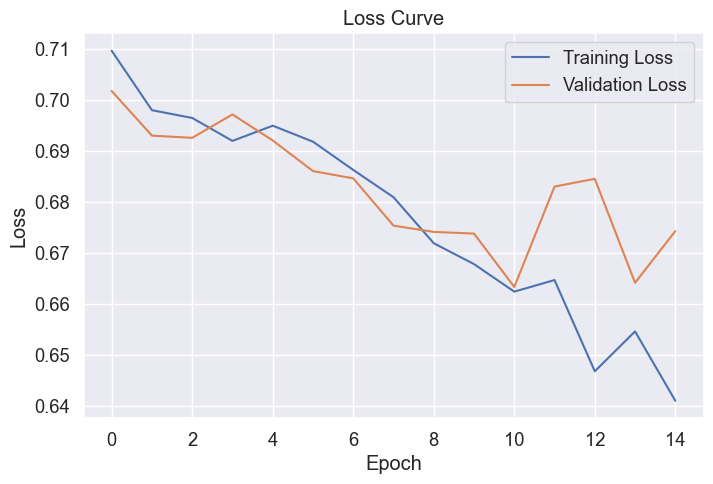

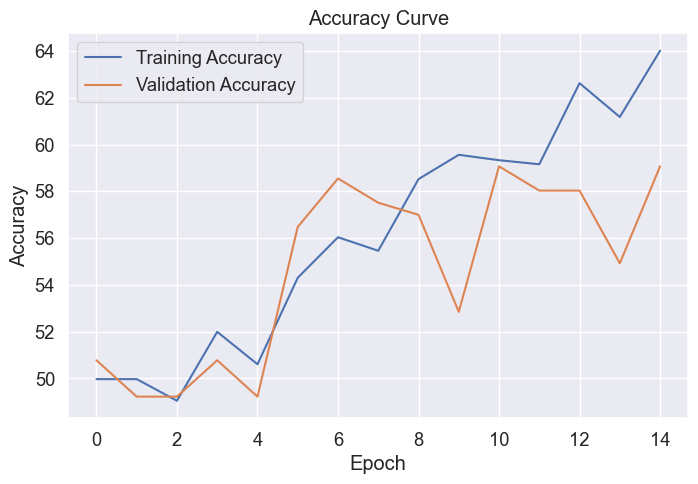

Test: [0/7]	Time 0.295 (0.295)	Loss 0.6055 (0.6055)	Accuracy 71.875 (71.875)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


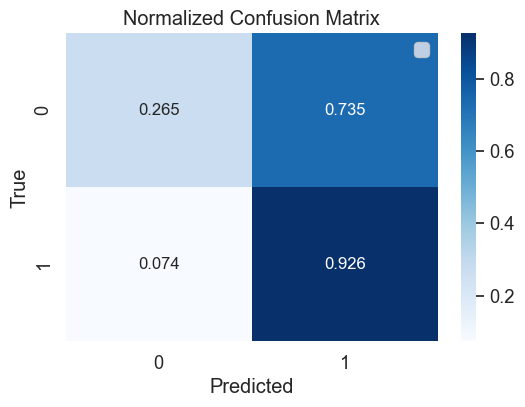

Maximum train accuracy: 64.00924321201617
Maximum test accuracy: 59.067357512953365
              precision    recall  f1-score   support

           0       0.79      0.27      0.40        98
           1       0.55      0.93      0.69        95

    accuracy                           0.59       193
   macro avg       0.67      0.60      0.54       193
weighted avg       0.67      0.59      0.54       193

Accuracy: 0.5906735751295337
F1 Score: 0.6901960784313725


In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score

utility.plot_learning_curves(train_losses_collatefn_30day, valid_losses_collatefn_30day, train_accuracies_collatefn_30day, valid_accuracies_collatefn_30day)

best_cnn_readmission_30day_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_30day_model_collatefn_fullDS.pth"))
valid_loss_collatefn_30day, valid_accuracy_collatefn_30day, valid_results_collatefn_30day = utility.evaluate(cnn_readmission_30day_model_collatefn, device, test_loader_readmission_30day_embed, criterion_collatefn_30day)

class_names = [0,1]
utility.plot_confusion_matrix(valid_results_collatefn_30day, class_names)

y_true_collatefn_30day, y_pred_collatefn_30day = zip(*valid_results_collatefn_30day)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracy_collatefn_30day)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies_collatefn_30day)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true_collatefn_30day, y_pred_collatefn_30day))
print("Accuracy:", accuracy_score(y_true_collatefn_30day, y_pred_collatefn_30day))
print("F1 Score:", f1_score(y_true_collatefn_30day, y_pred_collatefn_30day, average='binary'))

In [162]:
from utility import *
from ReadmissionCNN import *
import torch.nn as nn

In [181]:
class ReadmissionCNN_Enhanced(nn.Module):
    def __init__(self,n_filters, filter_sizes, output_dim, dropout, embedding_dim):
        super().__init__()
        
        # Since we already have embeddings, we won't use an embedding layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define convolutional layers independently
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_filters[0], kernel_size=(filter_sizes[0], embedding_dim))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n_filters[1], kernel_size=(filter_sizes[1], embedding_dim))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=n_filters[2], kernel_size=(filter_sizes[2], embedding_dim))
        self.conv4 = nn.Conv2d(in_channels=1, out_channels=n_filters[3], kernel_size=(filter_sizes[3], embedding_dim))

        # Define dropout layers for each convolutional layer
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)

        # Define pooling layers for each convolutional layer
        # Assuming global max pooling, so no need to define them here

        # Fully connected layer
        #self.fc1 = nn.Linear(sum(n_filters), output_dim)
        
        self.fc1 = nn.Linear(sum(n_filters), 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, embedded):
        self.activation_func = nn.LeakyReLU(0.05)
        
        #print(f'embed dimension before unsqueeze {embedded.shape}')
        conved1 = F.relu(self.conv1(embedded)).squeeze(3)
        pooled1 = F.max_pool1d(conved1, conved1.shape[2]).squeeze(2)
        dropped1 = self.dropout1(pooled1)

        # Apply second convolutional layer, ReLU, dropout, and pooling
        conved2 = F.relu(self.conv2(embedded)).squeeze(3)
        pooled2 = F.max_pool1d(conved2, conved2.shape[2]).squeeze(2)
        dropped2 = self.dropout1(pooled2)

        # Apply third convolutional layer, ReLU, dropout, and pooling
        conved3 = F.relu(self.conv3(embedded)).squeeze(3)
        pooled3 = F.max_pool1d(conved3, conved3.shape[2]).squeeze(2)
        dropped3 = self.dropout1(pooled3)

        # Apply third convolutional layer, ReLU, dropout, and pooling
        conved4 = F.relu(self.conv4(embedded)).squeeze(3)
        pooled4 = F.max_pool1d(conved4, conved4.shape[2]).squeeze(2)
        dropped4 = self.dropout4(pooled4)

        # Concatenate the pooled features from different convolutional layers
        cat = torch.cat((dropped1, dropped2, dropped3,dropped4), dim=1)
        # cat = [batch size, n_filters * len(filter_sizes)]
        
        x = self.dropout1(self.activation_func(self.fc1(cat))) 
        x = self.dropout2(self.activation_func(self.fc2(x))) 
        # Fully connected layer
        return self.fc3(x)

In [164]:
class VariedFilterReadmissionCNN(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, embedding_dim))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, embedding_dim))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5, embedding_dim))
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, output_dim)

    def forward(self, embedded):
        #embedded = embedded.unsqueeze(1)

        x = F.relu(self.conv1(embedded))
        x = F.max_pool2d(x, (2, 1))
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 1))
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.adaptive_max_pool2d(x, (1, 1)).view(x.size(0), -1)
        #x = self.dropout(x)

        return self.fc(x)

In [165]:
import math

BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

#batch_percent = 0.2
#readmission_balanced_dataset_len =  len(hf_readmission_notes_balanced)
#readmission_balanced_dataset_batchsize =  math.ceil(readmission_balanced_dataset_len * batch_percent)

# Create an instance of your custom dataset

readmission_train_dataset_noembed = TextDataset(X_readmission_train, y_readmission_train)
readmission_test_dataset_noembed = TextDataset(X_readmission_test, y_readmission_test)        

collate_fn = create_collate_fn(pubmed_pmc_wordvector, readmission_notes_len_cutoff)

train_loader_readmission_embed = torch.utils.data.DataLoader(readmission_train_dataset_noembed, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader_readmission_embed = torch.utils.data.DataLoader(readmission_test_dataset_noembed, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

#from ReadmissionCNN import *
PATH_OUTPUT = "./output_fullDS/readmission/"

# Hyperparameters
N_FILTERS = 1000  # number of filters
FILTER_SIZES = [3,4,5,6]  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = [0.4]  # dropout rate
EMBEDDING_DIM = 200  # embedding dimension

# Create an instance of the CNN class
#cnn_readmission_model_collatefn = ReadmissionCNN_Enhanced(N_FILTERS, FILTER_SIZES,OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
cnn_readmission_model_collatefn = ReadmissionCNN_Initial(N_FILTERS, FILTER_SIZES,OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)
#cnn_readmission_model_collatefn = VariedFilterReadmissionCNN(EMBEDDING_DIM,OUTPUT_DIM)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_readmission_model_collatefn = cnn_readmission_model_collatefn.to(device)

# Define loss function and optimizer
criterion_collatefn = nn.CrossEntropyLoss().to(device)
optimizer_collatefn = torch.optim.Adam(cnn_readmission_model_collatefn.parameters())


NUM_EPOCHS = 10
best_val_acc_collatefn = 0.0
train_losses_collatefn, train_accuracies_collatefn = [], []
valid_losses_collatefn, valid_accuracies_collatefn = [], []

for epoch in range(NUM_EPOCHS):

	train_loss_collatefn, train_accuracy_collatefn = utility.train(cnn_readmission_model_collatefn, device, train_loader_readmission_embed, criterion_collatefn, optimizer_collatefn, epoch)
	valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn = utility.evaluate(cnn_readmission_model_collatefn, device, test_loader_readmission_embed, criterion_collatefn)

	train_losses_collatefn.append(train_loss_collatefn)
	valid_losses_collatefn.append(valid_loss_collatefn)

	train_accuracies_collatefn.append(train_accuracy_collatefn)
	valid_accuracies_collatefn.append(valid_accuracy_collatefn)

	is_best_collatefn = valid_accuracy_collatefn > best_val_acc_collatefn  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best_collatefn:
		print(f"Best Validation Accuracy: {valid_accuracy_collatefn}")
		best_val_acc_collatefn = valid_accuracy_collatefn
		torch.save(cnn_readmission_model_collatefn, os.path.join(PATH_OUTPUT, "cnn_readmission_model_collatefn_fullDS.pth"), _use_new_zipfile_serialization=False)

TypeError: '<' not supported between instances of 'list' and 'int'

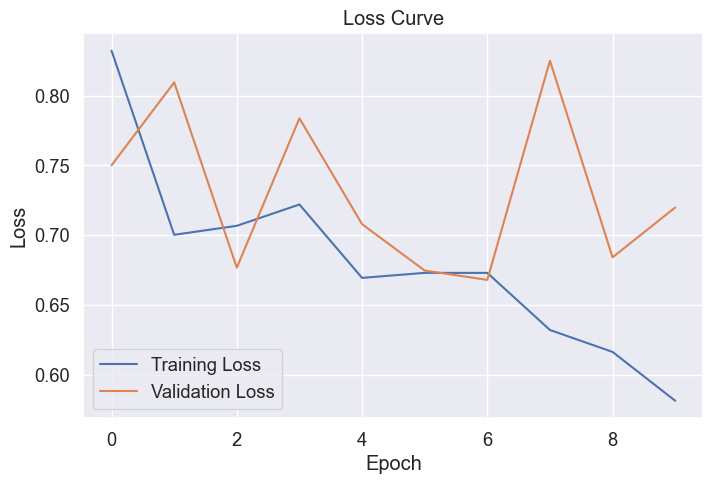

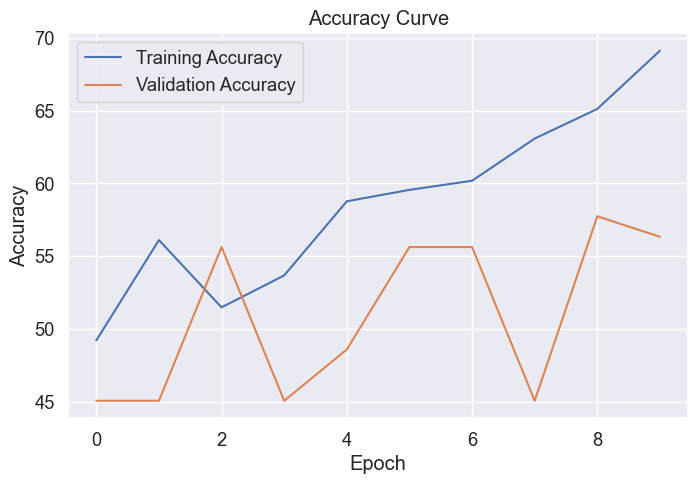

Test: [0/5]	Time 0.285 (0.285)	Loss 0.8459 (0.8459)	Accuracy 46.875 (46.875)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


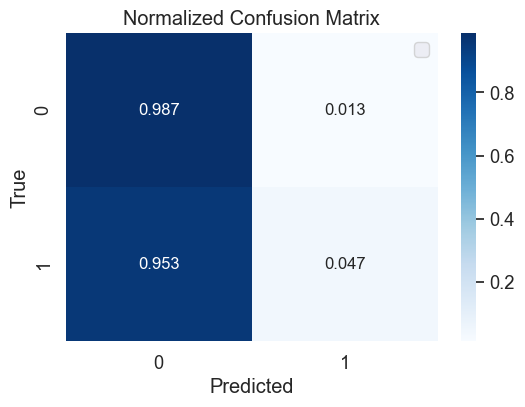

Maximum train accuracy: 69.12225707720813
Maximum test accuracy: 57.74647892696757
              precision    recall  f1-score   support

           0       0.56      0.99      0.71        78
           1       0.75      0.05      0.09        64

    accuracy                           0.56       142
   macro avg       0.65      0.52      0.40       142
weighted avg       0.64      0.56      0.43       142

Accuracy: 0.5633802816901409
F1 Score: 0.08823529411764706


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score

utility.plot_learning_curves(train_losses_collatefn, valid_losses_collatefn, train_accuracies_collatefn, valid_accuracies_collatefn)

best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_model_collatefn_fullDS.pth"))
valid_loss_collatefn, valid_accuracy_collatefn, valid_results_collatefn = utility.evaluate(cnn_readmission_model_collatefn, device, test_loader_readmission_embed, criterion_collatefn)

class_names = [0,1]
utility.plot_confusion_matrix(valid_results_collatefn, class_names)

y_true_collatefn, y_pred_collatefn = zip(*valid_results_collatefn)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracies_collatefn)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies_collatefn)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true_collatefn, y_pred_collatefn))
print("Accuracy:", accuracy_score(y_true_collatefn, y_pred_collatefn))
print("F1 Score:", f1_score(y_true_collatefn, y_pred_collatefn, average='binary'))